In [9]:
import os
import data
import model
import utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pprint import pprint


In [10]:
os.system('rm -rf graphs checkpoints')


0

In [17]:
data.load()
os.system('rm -rf graphs checkpoints')
hyper_params = {
    'num_features': 22050,
    'num_hiddens_fc': [2], 
    'num_classes': 2,
    'learning_rate': 1e-2
}

In [12]:
tf.reset_default_graph()
graph, model_vars = model.create_graph(hyper_params)

In [18]:
train_params = {
    'batch_size' : 128,
    'skip_step' : 50,
    'n_epochs' : 10000000
}

with tf.Session(graph=graph) as sess:
    # Mot vai thu tuc
    tf.global_variables_initializer().run()
    writer = tf.summary.FileWriter('./graphs/', sess.graph)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('./checkpoints/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    # Mot vai variable
    initial_step = model_vars['global_step'].eval()
    num_train, num_test = data.stats()
    print('num_train', num_train, 
          'num_test', num_test, 
          'n_batch',int(train_params['n_epochs'] * num_train/train_params['batch_size']), 
          'batch_per_epochs', int(num_train/train_params['batch_size']))
    train_batch = data.train_batch_generator(train_params['batch_size'])

    # Training
    for i in range(initial_step,  int(train_params['n_epochs'] * num_train/train_params['batch_size'])):
        X_batch, Y_batch = next(train_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch
        }
        batch_cost, _, summary = sess.run([model_vars['cost'], 
                                                      model_vars['optimizer'], 
                                                      model_vars['summary_op']], feed)
        writer.add_summary(summary, global_step=i)

        if i % train_params['skip_step'] == 0:
            print('batch', i, 'cost', batch_cost)
            saver.save(sess, './checkpoints/', i)


num_train 3801 num_test 951 n_batch 296953125 batch_per_epochs 29
batch 0 cost 4.28324
batch 50 cost 9.46728
batch 100 cost 8.86343
batch 150 cost 1.04779
batch 200 cost 2.17771
batch 250 cost 0.652715
batch 300 cost 0.00249893
batch 350 cost 0.583048
batch 400 cost 0.270434
batch 450 cost 0.000425952
batch 500 cost 0.416991
batch 550 cost 0.348491
batch 600 cost 1.063
batch 650 cost 0.445516
batch 700 cost 2.38515
batch 750 cost 0.454894
batch 800 cost 0.971666
batch 850 cost 0.637076
batch 900 cost 0.519784
batch 950 cost 0.740623
batch 1000 cost 9.11533
batch 1050 cost 3.14909
batch 1100 cost 10.9902
batch 1150 cost 23.0284
batch 1200 cost 37.9508
batch 1250 cost 55.8181
batch 1300 cost 16.8019
batch 1350 cost 1.32342
batch 1400 cost 0.0
batch 1450 cost 0.0
batch 1500 cost 0.0
batch 1550 cost 0.0
batch 1600 cost 0.0
batch 1650 cost 0.0
batch 1700 cost 0.0
batch 1750 cost 0.0
batch 1800 cost 0.0
batch 1850 cost 0.0
batch 1900 cost 0.0
batch 1950 cost 0.0
batch 2000 cost 0.0
batch 205

KeyboardInterrupt: 

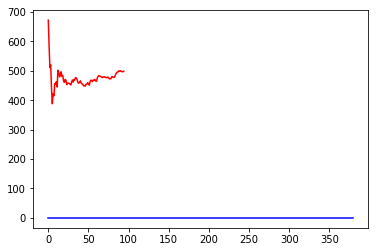

In [19]:
# Learning curve
train_params = {
    'batch_size' : 10,
    'skip_step' : 5,
    'n_epochs' : 1
}
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)    
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('./checkpoints/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    train_curve = []
    test_curve = []

    train_batch = data.train_batch_generator(train_params['batch_size'])
    test_batch = data.test_batch_generator(train_params['batch_size'])
    num_train, num_test = data.stats()

    cur_num = cur_cost = avg_cost = 0
    for i in range(int(num_train / train_params['batch_size'])):
        X_batch, Y_batch = next(train_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch,
        }
        cur_cost = sess.run(model_vars['cost'], feed)
        avg_cost = (avg_cost * cur_num + cur_cost * train_params['batch_size']) / (cur_num + train_params['batch_size'])
        cur_num += train_params['batch_size']
        train_curve.append(avg_cost)

        if i % 10 == 0:
            clear_output()
            plt.plot(train_curve, '-b')
            plt.plot(test_curve, '-r')
            plt.show()

    cur_num = cur_cost = avg_cost = 0
    
    for i in range(int(num_test / train_params['batch_size'])):
        X_batch, Y_batch = next(test_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch,
        }
        cur_cost = sess.run(model_vars['cost'], feed)
        avg_cost = (avg_cost * cur_num + cur_cost * train_params['batch_size']) / (cur_num + train_params['batch_size'])
        cur_num += train_params['batch_size']
        test_curve.append(avg_cost)

        
        if i % 10 == 0:
            clear_output()
            plt.plot(train_curve, '-b')
            plt.plot(test_curve, '-r')
            plt.show()

    clear_output()
    plt.plot(train_curve, '-b')
    plt.plot(test_curve, '-r')
    plt.show()